# Exoplanets HW3 
## Steven Stetzler and Miles Currie

### Problem 1

Install Rebound

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sys

In [2]:
rcParams['figure.figsize'] = [12, 10]
rcParams['font.size'] = 18

### Problem 2
Look up the parameters of the planet system GJ 876.  Assume the planets’ orbits lie in a plane, and vary the inclination of the system.  At what inclination does the system become unstable after 1000 orbits of the inner planet? What upper limit does this place on the planets’ masses?  At what inclination would the planets be seen to transit?  What lower limit does this place on the planets’ masses?


### From [Rivera et al. (2010)](https://iopscience.iop.org/article/10.1088/0004-637X/719/1/890/pdf):
<img src="GJ876_planet_params.png">
<img src="GJ876_stellar_params.png">

In [3]:
class Planet():
    def __init__(self, P, m, a, K, e, omega, mean_anomoly):
        self.P = P 
        self.m = m
        self.a = a
        self.K = K
        self.e = e
        self.omega = omega
        self.mean_anomoly = mean_anomoly
        
    def copy(self):
        return Planet(self.P, self.m, self.a, self.K, self.e, self.omega, self.mean_anomoly)

In [168]:
M_JUPITER_TO_M_EARTH = 317.828
M_SUN_TO_M_EARTH = 332948.6
M_EARTH_TO_M_SUN = 1. / M_SUN_TO_M_EARTH
M_JUPITER_TO_M_SUN = 1. / 1047.58
REF_INCLINATION = 59 * DEG_TO_RAD
M_STAR = 0.32

# 1 year = 365 days is 1 / (2 pi) yr / (2 pi)
# 365 * DAYS_TO_YEARS_OVER_2_PI = 1 / (2 * pi)
DAYS_TO_YEARS_OVER_2_PI = 2 * np.pi / (365.25)

DAYS_TO_YEARS = 1. / 365.25

DEG_TO_RAD = np.pi / 180.
RAD_TO_DEG = 180 / np.pi

In [58]:
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')
sim.G

39.476926421373

In [205]:
def build_sim_from_planets(planets, default_units=True):
    sim = rebound.Simulation()
    
    # Add center star
    if default_units:
        sim.units = ('yr', 'AU', 'Msun')
        sim.add(m=M_STAR)
    else:
        sim.units = ('days', 'AU', 'Mearth')
        sim.add(m=M_STAR * M_SUN_TO_M_EARTH)
        
    # Add all planets
    for planet in planets:
        sim.add(m=planet.m, a=planet.a, e=planet.e, M=planet.mean_anomoly, omega=planet.omega)

    # convert to center of mass coordinates
    sim.move_to_com()
    
    return sim

In [206]:
def run_simulation(planets, integration_time, plot=False, num_steps=10, archive_interval=None, 
                   default_units=True, dt=1e-3, **kwargs):   
    
    sim = build_sim_from_planets(planets, default_units=default_units)
    
    sim.dt = dt 
    sim.integrator = "whfast"
    
    if archive_interval is not None:
        sim.automateSimulationArchive("archive.bin", interval=archive_interval, deletefile=True)

    sim.move_to_com()
    
    if plot:
        for i in range(num_steps):
            sim.integrate(sim.t + integration_time / num_steps)
            fig = rebound.OrbitPlot(sim, color=True, unitlabel="[AU]")#, lim=1.2 * max([planet.a for planet in planets]))
            if default_units:
                fig.suptitle(f"{sim.t:0.2f} year" + f" {sim.t / sim.particles[1].P:0.2f} orbits")
            else:
                fig.suptitle(f"{sim.t:0.2f} {sim.units['time']} {sim.t / sim.particles[1].P:0.2f} orbits")
            display(fig)
            plt.close(fig)
            clear_output(wait=True)
        display(fig)
    else:
        sim.integrate(integration_time)
        
    return sim

In [173]:
def new_mass_estimate(m, m_star, i, i_new):
    t = 0

    A = m * np.sin(i) / (m_star + m)**(2/3)
    m_new = m
    while t < 100:
        B = (m_star + m_new)**(2/3) / np.sin(i_new)
        m_new = A * B
        
        t+=1
    
    return m_new

In [166]:
def modify_masses(planets, inclination, verbose=True, **kwargs):
    
    modified_masses = [new_mass_estimate(planet.m, M_STAR, REF_INCLINATION, inclination) for planet in planets]
    
    ret_planets = [planet.copy() for planet in planets]
    
    if verbose:
        print("Modified masses:")
        
    for ret_planet, modified_mass in zip(ret_planets, modified_masses):
        if verbose:
            print(f"  {ret_planet.m} --> {modified_mass}")
        ret_planet.m = modified_mass
    
    return ret_planets

In [167]:
def run_simulation_at_inclination(planets, inclination, integration_time, **kwargs):
    sim_planets = modify_masses(planets, inclination, **kwargs)
    
    return run_simulation(sim_planets, integration_time, **kwargs)

In [104]:
# Check if any of the orbits are within the Hill radius of one another
# Return True if orbits are unstable
# Return False if orbits are stable
def orbits_unstable(particles):
    positions = np.array([np.array([particle.x, particle.y, particle.z]) for particle in particles])
    distances = np.zeros((len(particles), len(particles)))
    
    def hill_spheres_intersect():
        r_H_list = [particle.a * (1-particle.e) * (particle.m / particles[0].m) for particle in particles[1:]]

        for i in range(len(particles)):
            for j in range(len(particles)):
                distances[i, j] = np.sqrt(np.sum((positions[i] - positions[j])**2))

        for i, (distance, r_H) in enumerate(zip(distances[1:], r_H_list)):
            distance_minus_r_H = distance - r_H
            negative_indices = np.where(distance_minus_r_H < 0)[0]
            negative_indices = [j for j in negative_indices if j != i + 1]
            if len(negative_indices) > 0:
                return True
            
        return False
    
    # Check if each planet's distance from the star is less than another planet's semi-major axis
    def orbits_cross():        
        semi_major_axes = [particle.a for particle in particles[1:]]
        
        semi_major_axes_sorted = np.sort(semi_major_axes)
        
        return not np.array_equal(semi_major_axes, semi_major_axes_sorted)
    
    return hill_spheres_intersect() or orbits_cross()

def simulation_unstable():
    sa = rebound.SimulationArchive("archive.bin")
    return np.any([orbits_unstable(sim.particles) for sim in sa])

In [463]:
inclinations = np.linspace(0.01, np.pi/2, 50)
stability_checks = []
for i, inclination in enumerate(inclinations):
    sim = run_simulation_at_inclination(planets, 
                                        inclination, 
                                        planets[0].P * 1000, 
                                        verbose=False,
                                        archive_interval=100)
    stability_checks.append(simulation_unstable())
    print(f"{100 * (i + 1) / len(inclinations)}% done   ", end="\r")
    sys.stdout.flush()

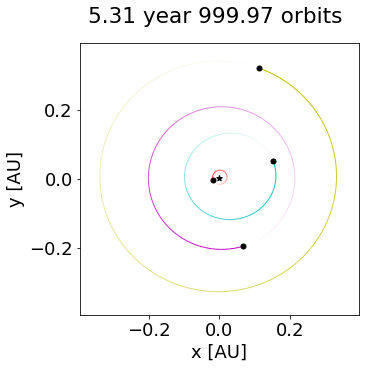

In [169]:
planets = [
    Planet(1.937780 * DAYS_TO_YEARS, 
           6.83 * M_EARTH_TO_M_SUN, 
           0.02080665, 
           6.56, 
           0.207, 
           234 * DEG_TO_RAD, 
           355 * DEG_TO_RAD),
    Planet(30.0881 * DAYS_TO_YEARS,
           0.7142 * M_JUPITER_TO_M_SUN, 
           0.129590, 
           88.34, 
           0.25591, 
           48.76 * DEG_TO_RAD, 
           294.59 * DEG_TO_RAD),
    Planet(61.1166 * DAYS_TO_YEARS, 
           2.2756 * M_JUPITER_TO_M_SUN, 
           0.208317, 
           214, 
           0.0324, 
           50.3 * DEG_TO_RAD, 
           325.7 * DEG_TO_RAD),
    Planet(124.26 * DAYS_TO_YEARS, 
           14.6 * M_EARTH_TO_M_SUN, 
           0.3343, 
           3.42, 
           0.055, 
           239 * DEG_TO_RAD, 
           335 * DEG_TO_RAD)
]

sim = run_simulation(planets, planets[0].P * 1000, archive_interval=None, 
                     plot=True, num_steps=10, default_units=True, dt=1e-5)

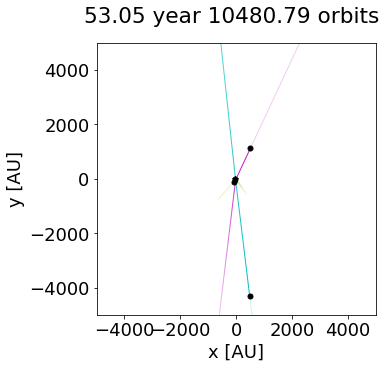

True

In [192]:
sim = run_simulation_at_inclination(planets, 10 * DEG_TO_RAD, planets[0].P * 10000, archive_interval=1/365,
                                    plot=True, num_steps=10, default_units=True, dt=1e-5)
simulation_unstable()

In [201]:
inclinations = np.linspace(0.001, np.pi / 2, 100)

stability_checks = []

for i, inclination in enumerate(inclinations):
    sim = run_simulation_at_inclination(planets, inclination, planets[0].P * 1000, archive_interval=1/10,
                                        plot=False, num_steps=10, default_units=True, dt=1e-5, verbose=False)
    stability_checks.append(simulation_unstable())
    print(f"{100 * i / len(inclinations):0.2f}% done!!!    ", end="\r")

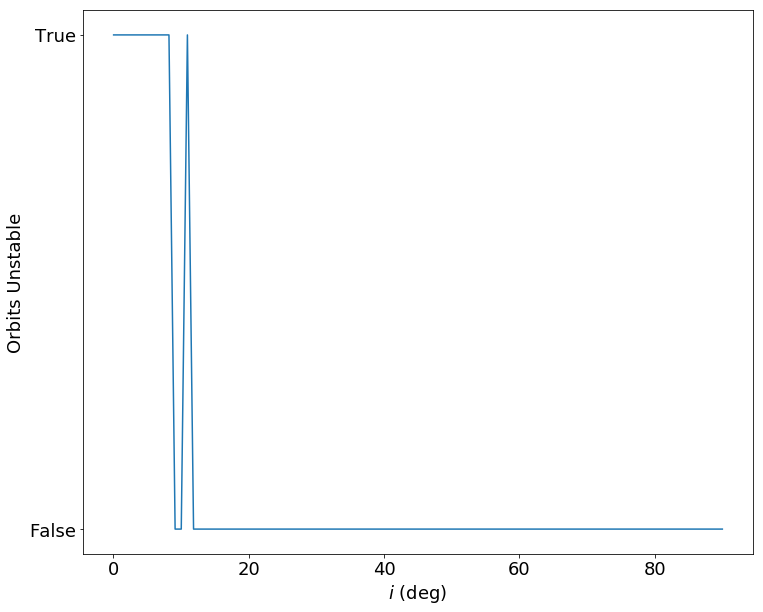

In [202]:
plt.plot(inclinations * 180 / np.pi, stability_checks)
plt.xlabel(r"$i$ (deg)")
plt.yticks([0, 1], ["False", "True"])
plt.ylabel("Orbits Unstable")
plt.show()

### Problem 3
Compute the radial velocity of the star, and then fit this RV with four Keplerian orbits. How big are the residuals?  How does this compare to typical RV errors?

### Problem 4
Look at REBOUND TTV example.  Make a plot of the TTVs of GJ 876 c over 4 years (assuming edge-on, so that planet would transit).  Measure amplitude and period of the sinusoidal variation component.  How does it change if you vary the mass of GJ 876 b downward and upward by a factor of 2?

In [233]:
# sim = rebound.Simulation()
# sim.add(m=1)
# sim.add(m=1e-5, a=1,e=0.1,omega=0.25)
# sim.add(m=1e-5, a=1.757)
# sim.move_to_com()

def TTV(planets, planet_b_mass):
    planets = [planet.copy() for planet in planets]
    planets[2].m = planet_b_mass

    sim = build_sim_from_planets(planets)
    sim.dt = 1e-4

    p = sim.particles

    planet_choice = 2
    N = int(4 / p[planet_choice].P)
    time_step = 0.1 * p[planet_choice].P
    transittimes = np.zeros(N)

    i = 0
    while i < N:
        y_old = p[planet_choice].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
        t_old = sim.t
        sim.integrate(sim.t + time_step) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
        t_new = sim.t
        if (y_old * (p[planet_choice].y - p[0].y) < 0.) and (p[planet_choice].x - p[0].x > 0.):   # sign changed (y_old*y<0), planet in front of star (x>0)
            while t_new - t_old > 1e-7:   # bisect until prec of 1e-5 reached
                if y_old * (p[planet_choice].y - p[0].y) < 0.:
                    t_new = sim.t
                else:
                    t_old = sim.t
                sim.integrate( (t_new + t_old) / 2.)
            transittimes[i] = sim.t
            i += 1
            sim.integrate(sim.t + time_step / 10)       # integrate 0.05 to be past the transit

    A = np.vstack([np.ones(N), range(N)]).T
    c, m = np.linalg.lstsq(A, transittimes)[0]

    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    ax.set_xlim([0, N])
    ax.set_xlabel("Transit number")
    ax.set_ylabel("TTV [hours]")

    TTV_detrended = (transittimes - m * np.array(range(N)) - c) * (24. * 365. / 2. / np.pi)
    ax.set_ylim([2 * min(TTV_detrended), 2 * max(TTV_detrended)])
    plt.scatter(range(N), TTV_detrended)
    plt.show()

/astro/users/stevengs/.conda/envs/Exoplanets/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


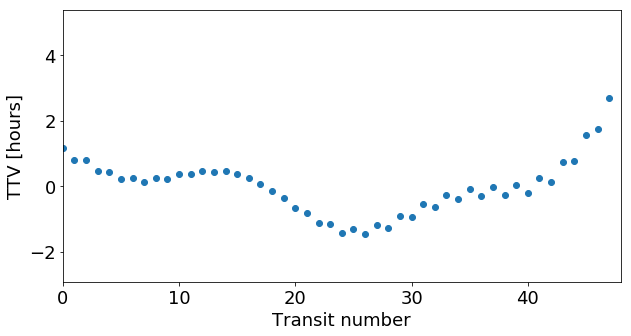

In [234]:
TTV(planets, planets[2].m)

/astro/users/stevengs/.conda/envs/Exoplanets/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


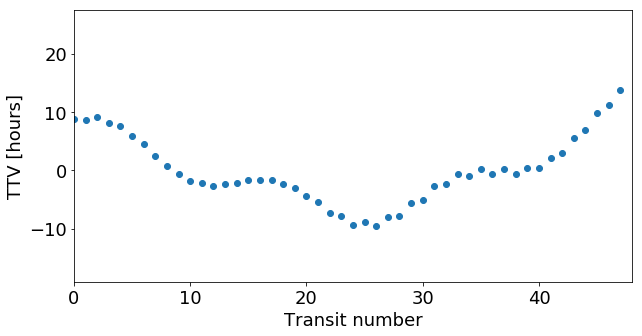

In [235]:
TTV(planets, 2 * planets[2].m)

/astro/users/stevengs/.conda/envs/Exoplanets/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


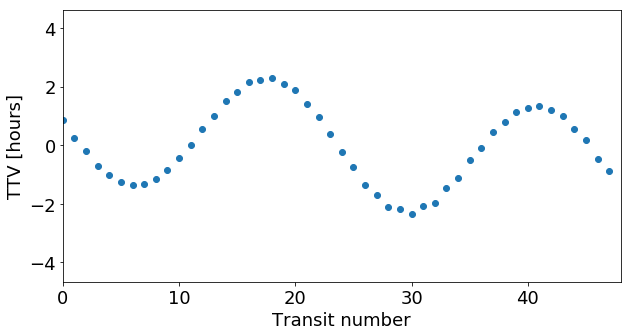

In [236]:
TTV(planets, 0.5 * planets[2].m)